In [1]:
import warnings
warnings.filterwarnings("ignore") 
import sys
import pandas as pd
from glob import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

In [2]:
pwd = os.getcwd()
path = pwd + '/MachineLearningCVE'
dfs = []
filenames = glob(path + "/*.csv")
filenames.sort()
for filename in filenames:
    dfs.append(pd.read_csv(filename))
    
df = pd.concat(dfs, ignore_index=True)
df['Flow Bytes/s'] = df['Flow Bytes/s'].astype(float)
df[' Flow Packets/s'] = df[' Flow Packets/s'].astype(float)
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], sys.maxsize)
#print("Columns which have NaN or NULLS: ")
#for col in df.columns:
#    print('%s: %d' % (col, df[col].isna().sum()))
substr = '�'
df[' Label'] = df[' Label'].str.replace(substr, '-')
y_labels = df[' Label'] 
encoding = {
        " Label": {"BENIGN": -1, "FTP-Patator": 1, "SSH-Patator": 1, "DoS slowloris": 1, 
                   "DoS Slowhttptest": 1, "DoS Hulk": 1, "DoS GoldenEye": 1, "Heartbleed": 1,
                   "Web Attack - Brute Force" : 1, "Web Attack - XSS": 1,
                   "Web Attack - Sql Injection": 1, "Infiltration" : 1, "Bot":1, "DDoS":1,
                   "PortScan": 1}
        }
df.replace(encoding, inplace=True)

In [3]:
full_data = df.drop(columns=[
    "Fwd Avg Bytes/Bulk",              
    " Fwd Avg Packets/Bulk",           
    " Fwd Avg Bulk Rate",              
    " Bwd Avg Bytes/Bulk",             
    " Bwd Avg Packets/Bulk", 
    "Bwd Avg Bulk Rate", 
    " Bwd PSH Flags", 
    " Bwd URG Flags"])

In [4]:
functional_features = ['Idle Mean',
 ' Idle Std',
 ' Idle Min',
 ' Idle Max',
 ' Avg Bwd Segment Size',
 ' Average Packet Size',
 ' URG Flag Count',
 'FIN Flag Count',
 ' Packet Length Variance',
 ' Packet Length Std',
 ' Packet Length Mean',
 ' Max Packet Length',
 ' Min Packet Length',
 ' Fwd IAT Max',
 ' Fwd IAT Std',
 ' Fwd IAT Mean',
 'Fwd IAT Total',
 ' Flow IAT Max',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Bwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Flow Duration']

In [5]:
functional_features = np.array([col in functional_features for col in full_data.columns[:-1]], dtype=np.float64)
nonFunctional_features = np.array([col not in functional_features for col in full_data.columns[:-1]], dtype=np.float64)

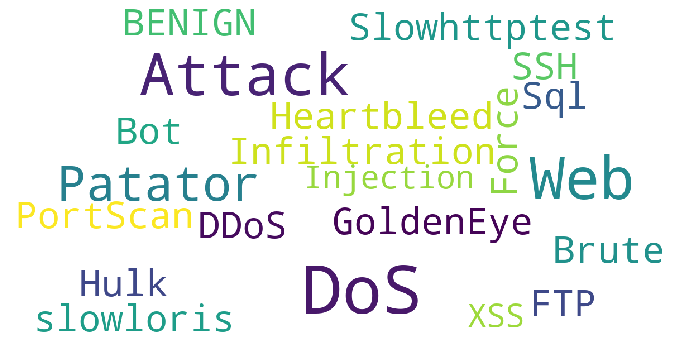

In [6]:
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
# Function to show the different attack cateegories present in the dataset

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):

    attack_catgs = data
    attack_catgs = np.unique(y_labels)
    text = " ".join(str(item) for item in attack_catgs)
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df)

In [7]:
# Plot to show the distribution of all attack categories

def plot_attack_category(data):
    sns.set(rc={'figure.figsize':(35,10),"font.size":50,"axes.titlesize":40,"axes.labelsize":15},style="white")
    catg_plot = sns.countplot(y_labels,data = data)
    for p in catg_plot.patches:
        height = p.get_height()
        catg_plot.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize = 15)

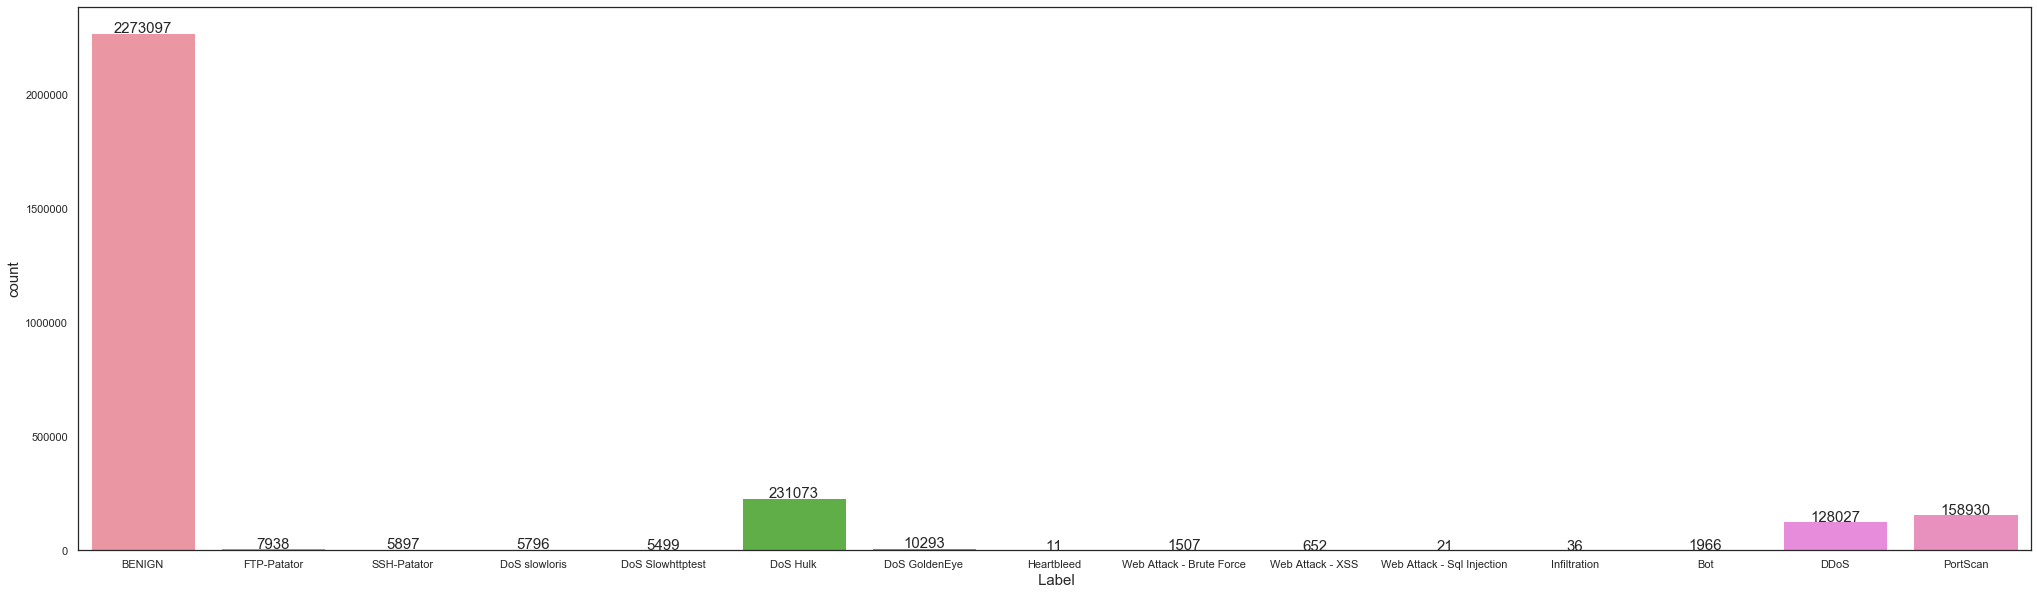

In [8]:
plot_attack_category(df)

In [9]:
def checker(arr):
    count_normals = 0
    count_attacks = 0
    for i in arr:
        if i != 1:
            count_normals += 1
        if i == 1:
            count_attacks += 1 
            
    #print("normals:", count_normals)
    #print("attacks:", count_attacks)
            
    return count_normals, count_attacks

In [10]:
def _toarray(X, Y):
    X = X.astype(float)
    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = Y.reshape(-1, 1)
    #Y = to_categorical(Y, 2)
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, Y
    
def _getData(df):
    _all = df
    _norm = df.loc[df[' Label'] != 1]
    _mal = df.loc[df[' Label'] == 1]
    #print(checker(_norm[' Label']))
    
    l_all = _all[' Label'][:,None]
    l_norm = _norm[' Label']
    l_mal = _mal[' Label']
    _all = _all.drop([' Label'], axis=1)
    _mal = _mal.drop([' Label'], axis=1)
    _norm = _norm.drop([' Label'], axis=1)
    data_all, label_all = _toarray(_all, l_all)
    data_mal, label_mal = _toarray(_mal, l_mal)
    data_norm, label_norm = _toarray(_norm, l_norm)
    
    return data_all, label_all, data_mal, label_mal, data_norm, label_norm

In [11]:
X_all, Y_all, malicious_data, Y_mal, normal_data, Y_norm = _getData(full_data)

In [12]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(full_data.iloc[:,:-1], full_data.iloc[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Using TensorFlow backend.


Resampled dataset shape Counter({-1: 557646, 1: 557646})


In [13]:
from sklearn.utils import shuffle
dataframe = pd.DataFrame(X_res)
dataframe[' Label'] = y_res 
dataframe = shuffle(dataframe).reset_index(drop=True)

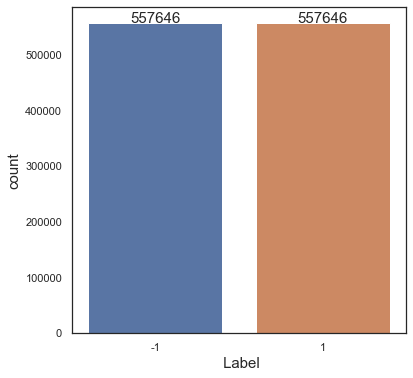

In [14]:
def plot_attack_category(data):
    sns.set(rc={'figure.figsize':(6,6),"font.size":50,"axes.titlesize":40,"axes.labelsize":15},style="white")
    catg_plot = sns.countplot(y_res,data = data)
    for p in catg_plot.patches:
        height = p.get_height()
        catg_plot.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize = 15)
plot_attack_category(df)

In [15]:
def _getCV(X, Y):
    XTrain = X[:int(0.8*len(X))]
    YTrain = Y[:int(0.8*len(Y))]
    XTest = X[int(0.8*len(X)):]
    YTest = Y[int(0.8*len(X)):]
    
    return XTrain, YTrain, XTest, YTest

In [16]:
X_all, Y_all, malicious_samples, Y_mal, normal_samples, Y_norm = _getData(dataframe)
malicious_data, normal_data, malicious_validation, normal_validation = _getCV(malicious_samples, normal_samples)
n_data = normal_data[int(len(normal_data)/2):]
m_data = np.vstack((malicious_data, malicious_data))

In [17]:
print("Malicious_data",malicious_samples.shape)
print("Normal_data",normal_samples.shape)
print("Training_Malicious",malicious_data.shape)
print("Validation_Malicious", malicious_validation.shape)
print("Training_Normal",normal_data.shape)
print("Validation_Normal", normal_validation.shape)

Malicious_data (557646, 70)
Normal_data (557646, 70)
Training_Malicious (446116, 70)
Validation_Malicious (111530, 70)
Training_Normal (446116, 70)
Validation_Normal (111530, 70)


In [18]:
mal_norm = np.vstack((m_data, n_data)) 
labels = np.hstack((np.ones(len(m_data)), -1 * np.ones(len(n_data))))
labels = labels.reshape(-1, 1)
data = np.hstack((mal_norm, labels))
np.random.shuffle(data)

In [19]:
def _getIDSdata(arr):
    data = []
    labels = []
    for i in range(0, len(arr)):
        a = arr[i][:-1]
        data.append(a)
        
        b = arr[i][-1:]
        labels.append(b)
        
    X = np.asarray(data)
    y = np.asarray(labels)
    return X, y

In [20]:
X, y = _getIDSdata(data)

In [21]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2)

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
mal_pred = clf.predict(malicious_data)
print("F1 Score Malcious Data: ", f1_score(np.ones_like(mal_pred), mal_pred, average='micro'))
print("MSE Malcious Data: ", mean_squared_error(np.ones_like(mal_pred), mal_pred))
norm_pred = clf.predict(normal_data)
print("F1 Score Normal Data: ", f1_score(-1*np.ones_like(norm_pred), norm_pred, average='micro'))
print("MSE Normal Data: ", mean_squared_error(-1*np.ones_like(norm_pred), norm_pred))

F1 Score Malcious Data:  1.0
MSE Malcious Data:  0.0
F1 Score Normal Data:  1.0
MSE Normal Data:  0.0


In [24]:
def _generator(input=(70,)):
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_shape=(70,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(np.prod(70,)))
    #model.add(layers.Activation('sigmoid'))
    
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2272      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3

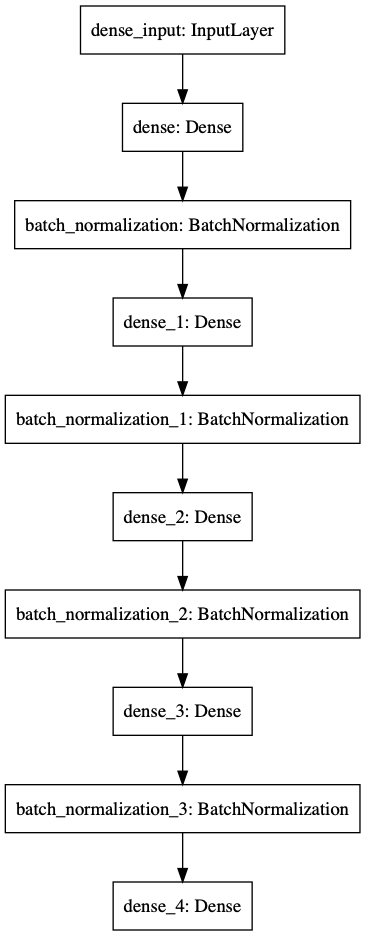

In [25]:
g = _generator()
tf.keras.utils.plot_model(g)

In [26]:
def _discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_shape=(70, )))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    #model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Dense(1))
    
    model.summary()
    
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               9088      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

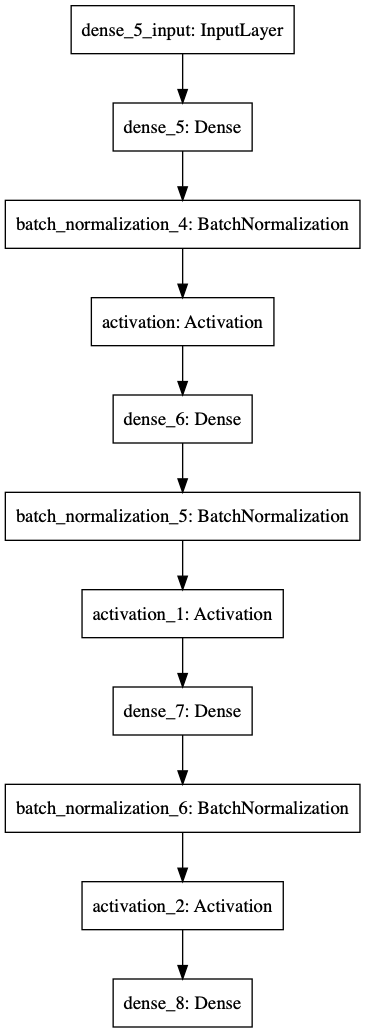

In [27]:
d = _discriminator()
tf.keras.utils.plot_model(d)

In [28]:
def get_batch(data, batch_size):
    indices = np.random.randint(low=0, high=len(data), size=batch_size)
    np.random.shuffle(indices)
    batch_data = data[indices]
    return batch_data

In [29]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [30]:
def discriminator_loss(d_normal, d_generated, predicted_attacks, predicted_normals):
    return tf.math.subtract(tf.reduce_mean(predicted_attacks * d_generated), 
                            (tf.reduce_mean(predicted_normals * d_normal)))
                            

In [31]:
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(d_generated):
    return tf.reduce_mean(d_generated) * 1

In [32]:
def _getPredictedNormalAttack(arr):
    n = []
    a = []
    for i in range(0, len(arr)):
        if arr[i][-1:] == -1:
            n.append(arr[i][:-1])
        if arr[i][-1:] == 1:
            a.append(arr[i][:-1])
            
    normal = np.asarray(n)
    attack = np.asarray(a)

    return normal, attack

In [33]:
def ids_compute(ids_classifer, ids_samples, batch_size):
    a = tf.make_tensor_proto(ids_samples)
    ids_samples = tf.make_ndarray(a)
    #print(ids_samples.shape)
    ids_preds = ids_classifer.predict(ids_samples)  
    _, _ = checker(ids_preds)
    #print(ids_preds.shape)
    mse = mean_squared_error(np.hstack([np.ones(int(len(ids_preds)/2)), -1*np.ones(int(len(ids_preds)/2))]), ids_preds)
    ids_preds = ids_preds.reshape(-1, 1)
    ids_stack = np.hstack((ids_samples, ids_preds))
    #print(ids_stack.shape)
    ids_normal, ids_attack = _getPredictedNormalAttack(ids_stack)
    #print("Predicted Normals: ", ids_normal.shape[0])
    #print("Predicted Attacks:", ids_attack.shape[0])
    predicted_attacks = ids_preds[:int(len(ids_preds)/2)]
    #print("Predicted Attacks:", predicted_attacks)
    predicted_normals = ids_preds[int(len(ids_preds)/2):]
    #print("Predicted Normal:", predicted_normals)
    ids_normal = tf.convert_to_tensor(ids_normal, float)
    ids_attack = tf.convert_to_tensor(ids_attack, float)
    ids_samples = tf.convert_to_tensor(ids_samples, float)
    predicted_attacks = tf.convert_to_tensor(predicted_attacks, float)
    predicted_normals = tf.convert_to_tensor(predicted_normals, float)
    

    return ids_samples, ids_normal, ids_attack, predicted_normals, predicted_attacks, mse

In [34]:
def _setTheshold(arr):
    a = tf.where(tf.less(arr, 0.0), 0, arr) 
    arr = tf.where(tf.greater(a, 1.0), 1, a)
  
    return arr

In [35]:
def plot_loss(losses):
    labels = ['Discriminator', 'Generator', 'IDS-Classifier']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.plot(losses.T[2], label='IDS-Classifier')
    plt.title("Training Losses")
    plt.legend()
    plt.savefig("Loss1_Plot.png")
    plt.show()

Epoch:  1/30 Discriminator Loss:-1.4986 Generator Loss:-1.8449 IDS Loss: 0.5410
Normal Samples: (1301, 70)
Attack Samples: (747, 70)
Epoch:  2/30 Discriminator Loss:-1.9078 Generator Loss:-3.9833 IDS Loss: 0.7500
Normal Samples: (1408, 70)
Attack Samples: (640, 70)
Epoch:  3/30 Discriminator Loss:-2.5316 Generator Loss:-6.6829 IDS Loss: 0.8359
Normal Samples: (1452, 70)
Attack Samples: (596, 70)
Epoch:  4/30 Discriminator Loss:-5.3828 Generator Loss:-10.8400 IDS Loss: 0.7188
Normal Samples: (1392, 70)
Attack Samples: (656, 70)
Epoch:  5/30 Discriminator Loss:-6.9042 Generator Loss:-17.0945 IDS Loss: 0.7500
Normal Samples: (1408, 70)
Attack Samples: (640, 70)
Epoch:  6/30 Discriminator Loss:-3.1024 Generator Loss:-21.9161 IDS Loss: 0.9902
Normal Samples: (1531, 70)
Attack Samples: (517, 70)
Epoch:  7/30 Discriminator Loss:-1.6647 Generator Loss:-20.0990 IDS Loss: 1.1426
Normal Samples: (1609, 70)
Attack Samples: (439, 70)
Epoch:  8/30 Discriminator Loss:-6.3716 Generator Loss:-20.2211 I

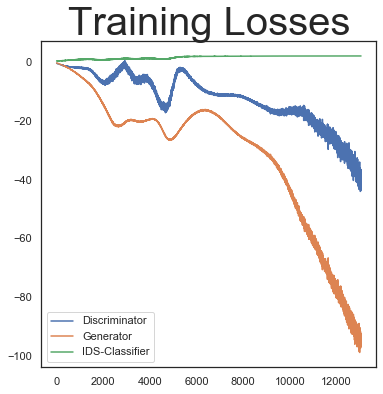

In [36]:
def train(epochs=30, batch_size=1024, functional_features=functional_features,
          nonFunctional_features=nonFunctional_features):
    
    losses = []
    ids, generator, discriminator = clf, g, d
    noise = generate_latent_points(70, batch_size)

    generator_optimizer = tf.keras.optimizers.RMSprop(6e-6) 
    discriminator_optimizer = tf.keras.optimizers.RMSprop(6e-6) 
    
    for e in range(epochs):
        for i in range(int(normal_data.shape[0]/batch_size)):
            normal_samples = get_batch(normal_data, batch_size=batch_size)
            malicious_samples = get_batch(malicious_data, batch_size=batch_size)
            generator_in = malicious_samples + noise
            #generator_in = noise
                        
            normal_samples = tf.convert_to_tensor(normal_samples, float)
            malicious_samples = tf.convert_to_tensor(malicious_samples, float)
            functional_features = tf.convert_to_tensor(functional_features, float)
            nonFunctional_features = tf.convert_to_tensor(nonFunctional_features, float)
            generator_in = tf.convert_to_tensor(generator_in, float)


            
            with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
                generated_maliciousSamples = tf.math.add(tf.math.multiply(malicious_samples, 
                                                                          functional_features), 
                                                         _setTheshold(tf.math.multiply(generator(generator_in), 
                                                                     nonFunctional_features)))
                
                #print(generated_maliciousSamples)
            
                ids_samples = tf.concat([generated_maliciousSamples, normal_samples], 0)
                #print(ids_samples.shape)
#                 ids_samples = tf.Session().run(ids_samples)
#                 ids_predictions = ids.predict(ids_samples)
                _, ids_normal, ids_attack, predicted_normals, predicted_attacks, ids_loss = ids_compute(ids, ids_samples, 
                                                                                  batch_size=batch_size)
                #print(ids_predictedAttacks.shape)
                #print("ids loss:", ids_loss)
                     
                d_normal = discriminator(normal_samples)
                d_gAttack = discriminator(generated_maliciousSamples)
                
             
                
                #d_loss = tf.math.subtract(tf.reduce_mean(d_normal), tf.reduce_mean(d_gAttack))
                d_loss = discriminator_loss(d_normal, d_gAttack, predicted_attacks, predicted_normals)
                #print("dloss:", d_loss)

                d_gSamples = discriminator(generated_maliciousSamples)
            
                g_loss = generator_loss(d_gSamples)
                #print("gloss:", g_loss)
    
            gGradients = gTape.gradient(g_loss, generator.trainable_variables)
            dGradients = dTape.gradient(d_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gGradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(dGradients, discriminator.trainable_variables))
            losses.append((d_loss, g_loss, ids_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f} IDS Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss, ids_loss)) 
        print('Normal Samples:', ids_normal.shape)
        print('Attack Samples:', ids_attack.shape)
    
    plot_loss(losses)

    return generator

gen = train()
gen.save('AdvTrafficGenerator.h5')

In [46]:
def _map(arr):
    outs = []
    for i in range(0, len(arr)):
        if arr[i] == 1:
            outs.append('MALICIOUS ATTACK!!')
        if arr[i] == -1:
            outs.append('NORMAL DATA')
    outs = np.asarray(outs)
    outs = outs.reshape(-1, 1)
    
    return outs

def _CV(generator=gen, ids=clf, 
        CV_attack=malicious_validation, 
        functional_features=functional_features, 
        nonFunctional_features=nonFunctional_features):

    attack_preds = ids.predict(CV_attack)
    mse_attack = mean_absolute_error(np.ones(len(attack_preds)), attack_preds)
    dr_attack = np.sum(attack_preds == np.ones(len(attack_preds))) / len(CV_attack)
    
    advAttacks = np.add(np.multiply(CV_attack, functional_features), 
                        (np.multiply(generator(CV_attack), nonFunctional_features)))
    
    advAttacks_preds = ids.predict(advAttacks)
    mse_advAttacks = mean_absolute_error(np.ones(len(advAttacks_preds)), advAttacks_preds)
    dr_advAttack = np.sum(advAttacks_preds == np.ones(len(advAttacks_preds))) / len(advAttacks)

    evasion_increase_rate = 1 - ((np.sum(advAttacks_preds == np.ones(len(advAttacks_preds))) / len(advAttacks)) 
                                      / (np.sum(attack_preds == np.ones(len(attack_preds))) / len(CV_attack)))
    print("Few Original Malicious attacks Samples as Predicted by the IDS: ", '\n', 65*'-', '\n',
         _map(attack_preds[-10:]), '\n',  65*'-', '\n', "Detection System MSE: ", mse_attack, 
          '\n', "Detection Rate: ", dr_attack)
    print('\n')
    print("Converted Adversial Samples as Predicted by the IDS:", '\n', 65*'-', '\n',
         _map(advAttacks_preds[-10:]), '\n', 65*'-', '\n', "Detection System MSE: ", mse_advAttacks, 
          '\n', "Detection Rate: ", dr_advAttack)
    print('\n Evasion Increase Rate (EIR): ',evasion_increase_rate)
_CV()

Few Original Malicious attacks Samples as Predicted by the IDS:  
 ----------------------------------------------------------------- 
 [['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']
 ['MALICIOUS ATTACK!!']] 
 ----------------------------------------------------------------- 
 Detection System MSE:  0.0 
 Detection Rate:  1.0


Converted Adversial Samples as Predicted by the IDS: 
 ----------------------------------------------------------------- 
 [['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']
 ['NORMAL DATA']] 
 ----------------------------------------------------------------- 
 Detection System MSE:  2.0 
 Detection Rate:  0.0

 Evasion Increase Rate (EIR):  1.0



Normal data samples:  111530
Malicious data samples:  111530
Generated data samples:  111530

Test data size:  (334590, 70)
Test data labels (334590, 1)

F1 Score:  0.6698668733880947

Accuracy Score:  0.6690725963119041

MSE:  1.3237096147523835

Confusion Matrix: 
 [[111530      0]
 [110725 112335]]


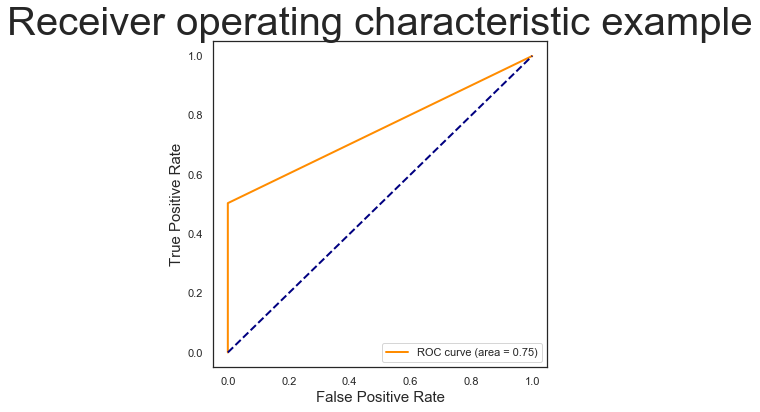

In [47]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

def _test(generator=gen, ids=clf, 
        malicious=malicious_validation, 
        normal = normal_validation,
        functional_features=functional_features, 
        nonFunctional_features=nonFunctional_features):
    noise = generate_latent_points(70, malicious.shape[0])
    malicious_samples = get_batch(malicious_data, batch_size=malicious.shape[0])
    generated = generator(noise)
    print("\nNormal data samples: ",normal.shape[0])
    print("Malicious data samples: ",malicious.shape[0])
    print("Generated data samples: ",generated.shape[0])

    advAttacks = np.add(np.multiply(malicious_samples, functional_features), 
                        np.multiply(generated, nonFunctional_features))
    normal_labels = -1*np.ones(normal.shape[0]).reshape(-1,1)
    malicious_labels = np.ones(malicious.shape[0]).reshape(-1,1)
    generated_labels = np.ones(generated.shape[0]).reshape(-1,1)

    x_test = np.concatenate( (normal,malicious,generated), axis = 0)
    y_test = np.concatenate( (normal_labels, malicious_labels, generated_labels), axis = 0)

    print("\nTest data size: ",x_test.shape)
    print("Test data labels", y_test.shape)

    predictions = ids.predict(x_test)

    print("\nF1 Score: ", f1_score(y_test, predictions))
    print("\nAccuracy Score: ", accuracy_score(y_test, predictions))
    print("\nMSE: ", mean_squared_error(y_test, predictions))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, predictions))
  
    fpr, tpr, _ = roc_curve(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('Score_Metrics1.png')
    plt.show()

_test()


Test data size:  (223058, 70)
Test data labels (223058, 1)

F1 Score:  1.0

Accuracy Score:  1.0

MSE:  0.0

Confusion Matrix: 
 [[ 44468      0]
 [     0 178590]]


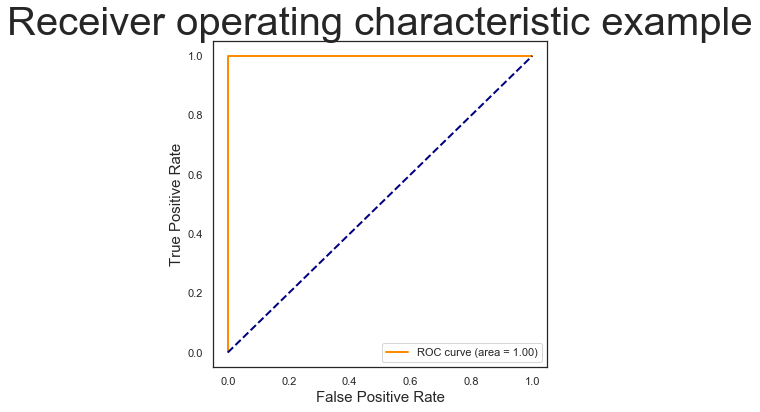

In [44]:
def _testnormal(ids=clf, x_test= X_test, y_test = y_test):
    
    print("\nTest data size: ",x_test.shape)
    print("Test data labels", y_test.shape)

    predictions = ids.predict(x_test)

    print("\nF1 Score: ", f1_score(y_test, predictions))
    print("\nAccuracy Score: ", accuracy_score(y_test, predictions))
    print("\nMSE: ", mean_squared_error(y_test, predictions))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, predictions))
  
    fpr, tpr, _ = roc_curve(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('Score_Metrics2.png')
    plt.show()
_testnormal()